In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import os

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

import random
from deap import base, creator, tools, algorithms

from cuml.svm import LinearSVC as cuSVC
from cuml import LogisticRegression as cuLR
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.naive_bayes import GaussianNB as cuNB
from sklearn.naive_bayes import GaussianNB as skNB
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.svm import LinearSVC as skSVC
from sklearn.linear_model import LogisticRegression as skLR

import shap

from joblib import Parallel, delayed, load, dump

from collections import defaultdict
import time
import gc

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# setting individual creator
creator.create('FitnessMulti', base.Fitness, weights=(1, -1))
creator.create('Individual', list, fitness=creator.FitnessMulti)

def has_converged(series, w, eps):
    if w >= len(series):
        return False

    current = series[len(series)-1]
    window = series[-w-1:-1]
    average_error = np.mean(np.abs(window-current)/np.abs(current))
    return average_error <= eps

def evaluate(individual, model, X, y, gamma, r_eps, r_w, s_eps, s_w):
    n = len(X)
    b = round(n**gamma)
    subset_scores = []
    while not has_converged(subset_scores, s_w, s_eps):
        subsample_idx = random.sample(range(n), b)
        X_sampled = X[subsample_idx, :][:, individual]
        y_sampled = y[subsample_idx]
        train, test = train_test_split(np.arange(b), test_size=0.33, stratify=y_sampled, random_state=42)
        monte_carlo_scores = []
        while not has_converged(monte_carlo_scores, r_w, r_eps):
            sample_weights = np.random.multinomial(n=n, pvals=[1/b]*b, size=1)[0]
            clf = clone(model)
            clf.fit(X=X_sampled[train, :], 
                    y=y_sampled[train], 
                    sample_weight=sample_weights[train])
            monte_carlo_scores.append(
                roc_auc_score(y_sampled[test], 
                       clf.predict_proba(X_sampled[test, :]),
                       sample_weight=sample_weights[test],
                       multi_class="ovr")
            )
        subset_scores.append(np.mean(monte_carlo_scores))
    return np.mean(subset_scores), np.count_nonzero(individual)

class GATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):   
        self.model = model
    
    def fit(self, X, y=None):
        # memmapping for later
        X_path = "cache/X_memmap.mmap"
        if os.path.exists(X_path): os.unlink(X_path)
        y_path = "cache/y_memmap.mmap"
        if os.path.exists(y_path): os.unlink(y_path)
        dump(X, X_path)
        dump(y, y_path)

        del X, y
        gc.collect()

        X_memmap = load(X_path, mmap_mode="r+")
        y_memmap = load(y_path, mmap_mode="r+")

        toolbox = base.Toolbox()
        
        n_features = X_memmap.shape[1]
        toolbox.register('attr_bool', random.choice, [True, False])
        toolbox.register(
            'individual', tools.initRepeat, creator.Individual,
            toolbox.attr_bool, n=n_features)
        toolbox.register(
            'population', tools.initRepeat, list, toolbox.individual)

        # raise population
        pop = toolbox.population(10)

        toolbox.register('mate', tools.cxTwoPoint)
        toolbox.register('mutate', tools.mutFlipBit, indpb=0.2)
        toolbox.register('evaluate', evaluate, model=self.model, 
                         gamma=0.63, r_eps = 0.04, r_w = 20, s_eps = 0.025, s_w = 5)
        toolbox.register('select', tools.selNSGA2)
        
        perf_stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
        n_feat_stats = tools.Statistics(key=lambda ind: ind.fitness.values[1])
        mstats = tools.MultiStatistics(perf=perf_stats, n_features=n_feat_stats)
        mstats.register("mean", np.mean)
        mstats.register("max", max)
        mstats.register("min", min)

        hof = tools.HallOfFame(3)

        mu = 10
        lambda_ = 20
        cxpb = 0.5
        mutpb = 0.5
        ngen = 40

        logbook = tools.Logbook()
        logbook.header = ['gen', 'nevals'] + mstats.fields

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = Parallel(n_jobs=6, max_nbytes=None)(
            delayed(toolbox.evaluate)(list(ind), X=X_memmap, y=y_memmap) for ind in invalid_ind
        )
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        hof.update(pop)

        # no real selecting, only to assign crowding distance
        pop = toolbox.select(pop, len(pop))

        record = mstats.compile(pop)
        logbook.record(gen=0, nevals=len(invalid_ind), **record)
        print(logbook.stream)

        with Parallel(n_jobs=6, max_nbytes=None) as parallel:
            for gen in range(1, ngen+1):
                offspring = algorithms.varOr(pop, toolbox, lambda_, cxpb, mutpb)

                # Evaluate the individuals with an invalid fitness
                invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                fitnesses = parallel(delayed(toolbox.evaluate)
                                     (list(ind), X=X_memmap, y=y_memmap) for ind in invalid_ind)
                for ind, fit in zip(invalid_ind, fitnesses):
                    ind.fitness.values = fit
                
                hof.update(pop)

                # Select the next generation population
                pop[:] = toolbox.select(pop + offspring, mu)

                record = mstats.compile(pop)
                logbook.record(gen=gen, nevals=len(invalid_ind), **record)
                print(logbook.stream)
        
        self.logbook = logbook

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Number of generations')
        ax1.set_ylabel('AUC')
        ax1.plot(logbook.chapters['auc'].select("gen"), logbook.chapters['auc'].select("max"), label="Max AUC")

        ax2 = ax1.twinx()
        ax2.set_ylabel('Number of features')
        ax2.plot(logbook.chapters['n_features'].select("gen"), logbook.chapters['n_features'].select("min"), label="Min features")

        fig.suptitle(f'GA Transformer Evolution: {type(self.model).__name__}')
        fig.legend()
        fig.tight_layout()
        
        plt.show()
        
        self.best_features = hof[0]
        return self
    
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [name for name, selected in zip(input_features, self.best_features) if selected]
        else:
            return [name for name, selected in zip(self.feature_names_in_, self.best_features) if selected]
        
    def transform(self, X, y=None):
        return X[:, self.best_features]
    
    def get_logbook(self):
        return self.logbook
    
    def get_params(self, deep=True):
        return {"model": self.model}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
train_df = pd.read_parquet("data/BaIoT/danmini_multiclass_train.parquet")
X_train = train_df.drop(['traffic_type'], axis=1)
y_train = LabelEncoder().fit_transform(train_df['traffic_type'])
print(f"X_train shape is {X_train.shape}")
del train_df

test_df = pd.read_parquet("data/BaIoT/danmini_multiclass_test.parquet")
X_test = test_df.drop(['traffic_type'], axis=1)
y_test = LabelEncoder().fit_transform(test_df['traffic_type'])
print(f"X_test shape is {X_test.shape}")
del test_df

X_train shape is (2091452, 115)
X_test shape is (203660, 115)


In [4]:
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    precision, recall, f1_score, support = precision_recall_fscore_support(y, y_pred, average=None, zero_division=1)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "support": support,
        "roc_auc_score": roc_auc_score(y, clf.predict_proba(X), average="weighted", multi_class="ovr")
    }

fitting GA now
   	      	              n_features              	                     perf                     
   	      	--------------------------------------	----------------------------------------------
gen	nevals	gen	max	mean	min	nevals	gen	max    	mean    	min    	nevals
0  	10    	0  	66 	59.6	54 	10    	0  	0.98839	0.987033	0.98474	10    
1  	20    	1  	62 	56.8	52 	20    	1  	0.989756	0.988362	0.98644	20    
2  	20    	2  	62 	53.3	48 	20    	2  	0.989756	0.98855 	0.986759	20    
3  	20    	3  	62 	51.9	45 	20    	3  	0.989756	0.988671	0.987214	20    
4  	20    	4  	62 	50.5	43 	20    	4  	0.989756	0.98874 	0.98711 	20    
5  	20    	5  	57 	48.4	43 	20    	5  	0.989756	0.988527	0.986897	20    
6  	20    	6  	57 	48.4	40 	20    	6  	0.989756	0.988898	0.986897	20    
7  	20    	7  	57 	48  	40 	20    	7  	0.989756	0.989115	0.987242	20    
8  	20    	8  	57 	46  	38 	20    	8  	0.989756	0.988931	0.987148	20    
9  	20    	9  	57 	46.4	38 	20    	9  	0.989756	0.989051	0.987148	

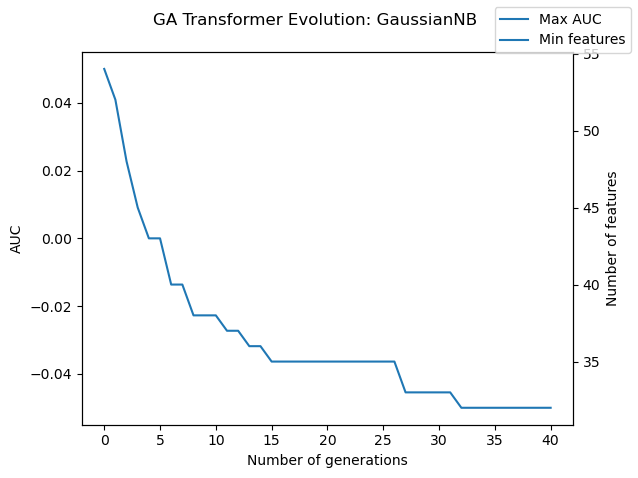

Took 630.4678528308868 seconds to fit GA
fitting models with FS now
-------------------------------
Starting fit with GA selection for GaussianNB()
-------------------------------
-------------------------------
Results for GaussianNB() with GA selection: 
{'accuracy': 0.8802170283806344, 'precision': array([0.99979704, 0.67234719, 0.56326531, 0.99966239, 0.15740741,
       0.53461568, 1.        , 1.        , 1.        , 1.        ,
       0.99920766]), 'recall': array([9.94147326e-01, 9.90957803e-01, 2.37398933e-02, 9.91959799e-01,
       9.22509225e-04, 9.98866588e-01, 9.99706444e-01, 9.98374890e-01,
       9.99224964e-01, 9.99810658e-01, 9.99878019e-01]), 'f1_score': array([0.99696418, 0.80113713, 0.04555959, 0.9957962 , 0.00183427,
       0.69646679, 0.9998532 , 0.99918678, 0.99961233, 0.99990532,
       0.99954272]), 'support': array([ 9910, 11944,  5813,  5970, 18428, 21175, 20439, 21537, 24515,
       47533, 16396]), 'roc_auc_score': 0.9786577677806175, 'model': 'GaussianNB', 'n

To use pickling first train using float32 data to fit the estimator


-------------------------------
Results for RandomForestClassifier() with GA selection: 
{'accuracy': 0.9920308357065698, 'precision': array([0.9993948 , 0.8843664 , 0.9861079 , 0.9998325 , 1.        ,
       0.99990554, 1.        , 1.        , 1.        , 1.        ,
       1.        ]), 'recall': array([0.99979818, 0.99506028, 0.73266816, 0.9998325 , 0.9998372 ,
       0.9998111 , 1.        , 1.        , 1.        , 1.        ,
       1.        ]), 'f1_score': array([0.99959645, 0.93645353, 0.84070272, 0.9998325 , 0.9999186 ,
       0.99985832, 1.        , 1.        , 1.        , 1.        ,
       1.        ]), 'support': array([ 9910, 11944,  5813,  5970, 18428, 21175, 20439, 21537, 24515,
       47533, 16396]), 'roc_auc_score': 0.9999743394240206, 'model': 'RandomForestClassifier', 'n_features': 51, 'time': 57.45788311958313}
Took 57.45788311958313 seconds
-------------------------------
-------------------------------
Starting fit with GA selection for LogisticRegression()
------

To use pickling first train using float32 data to fit the estimator


-------------------------------
Results for RandomForestClassifier() with GA selection: 
{'accuracy': 0.9845674162820387, 'precision': array([0.9993948 , 0.95578423, 0.98965777, 0.99966505, 1.        ,
       0.89325345, 1.        , 1.        , 1.        , 1.        ,
       1.        ]), 'recall': array([0.99979818, 0.99539518, 0.90538448, 0.9998325 , 0.86265466,
       0.9998111 , 1.        , 1.        , 1.        , 1.        ,
       1.        ]), 'f1_score': array([0.99959645, 0.97518763, 0.94564729, 0.99974876, 0.92626366,
       0.94353329, 1.        , 1.        , 1.        , 1.        ,
       1.        ]), 'support': array([ 9910, 11944,  5813,  5970, 18428, 21175, 20439, 21537, 24515,
       47533, 16396]), 'roc_auc_score': 0.9999897215951526, 'model': 'RandomForestClassifier', 'n_features': 115, 'time': 115.40329051017761}
Took 115.40329051017761 seconds
-------------------------------
-------------------------------
Starting fit for LogisticRegression()
---------------------

In [5]:
models = [skNB(), 
          cuRF(n_estimators = 500),
          cuLR(max_iter=5000),
          cuSVC(probability=True),
          cuKNN(n_neighbors=17)]
results = defaultdict(list)

print("fitting GA now")
start = time.time()
transform_pipe = make_pipeline(StandardScaler(), GATransformer(model=skNB()))
transform_pipe.fit(X_train, y_train)
end = time.time()
print(f"Took {end - start} seconds to fit GA")

results['logbook'] = transform_pipe['gatransformer'].get_logbook()

X_train_selected = transform_pipe.transform(X_train)
X_test_selected = transform_pipe.transform(X_test)

print("fitting models with FS now")

for model in models:
    print("-------------------------------")
    print(f"Starting fit with GA selection for {model}")
    print("-------------------------------")
    start = time.time()
    clf = clone(model)
    clf.fit(X_train_selected, y_train)
    scores = custom_scorer(clf, X_test_selected, y_test)
    end = time.time()
    scores['model'] = type(model).__name__
    scores['n_features'] = X_train_selected.shape[1]
    scores['time'] = end - start
    print("-------------------------------")
    print(f"Results for {model} with GA selection: ")
    print(scores)
    print(f"Took {end - start} seconds")
    print("-------------------------------")
    results['fs_scores'].append(scores)

print("fitting models without FS now")

for model in models:
    print("-------------------------------")
    print(f"Starting fit for {model}")
    print("-------------------------------")
    start = time.time()
    clf = clone(model)
    clf.fit(transform_pipe[0].transform(X_train), y_train)
    scores = custom_scorer(clf, transform_pipe[0].transform(X_test), y_test)
    end = time.time()
    scores['model'] = type(model).__name__
    scores['n_features'] = X_train.shape[1]
    scores['time'] = end - start
    print("-------------------------------")
    print(f"Results for {model} with GA selection: ")
    print(scores)
    print(f"Took {end - start} seconds")
    print("-------------------------------")
    results['no_fs_scores'].append(scores)

In [6]:
with open('baiot_results_blb_no_cv_multiclass.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)